# Bank Customer Churn Analytics

The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

## Dataset details

The dataset in churn.csv contains the churn status of 10,000 customers, along with 14 attributes that include:

- **RowNumber**
- **CustomerId**
- **Surname**
- **CreditScore** - Customer's credit score
- **Geography** - Geographical location
- **Gender (male, female)**
- **Age**
- **Tenure** - number of years the person was a customer at that bank
- **Balance** - Account balance
- **EstimatedSalary** - Estimated salary
- **NumOfProducts** - Number of products that a customer purchased through the bank
- **HasCrCard** - Credit card status (whether or not a customer has a credit card)
- **IsActiveMember** - Active member status (whether or not the person is an active bank customer)
- **Exited** - Whether a customer has left the bank or not

#### Import Relevant Libraries

In [47]:
# import relevant libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate, KFold
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
# observing the dataset

df_cc_raw = pd.read_csv("churn.csv")
df_cc_raw.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
df_cc_raw.shape

(10000, 14)

In [4]:
df_cc_raw[df_cc_raw['Exited'] == 0].shape

(7963, 14)

In [5]:
df_cc_raw[df_cc_raw['Exited'] == 1].shape

(2037, 14)

#### Only around 20% left the bank - there is a class imbalance ratio that needs to be dealt with. This will be dealt with under the Model Building section of this report using SMOTE. 

## Data Cleaning and Transformation

In [6]:
# changing column names to more appropriate names
df_cc_raw.rename(columns = {'Geography':'Country'}, inplace=True)
df_cc_raw.head(1)

,RowNumber,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [7]:
# dropping duplicate rows
df_cc_raw.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)

In [8]:
# dropping RowNumber, CustomerId, Surname columns as they are irrelevant in customer churn prediction
df_cc_raw.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df_cc_raw.shape

(10000, 11)

In [9]:
# checking for NA values
df_cc_raw.isna().sum()

CreditScore        0
Country            0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

The columns do not have any rows with NA values. It would also be a good idea to check the type of data in each column to observe if there is anything peculiar.

In [10]:
# observing type of data in each column
df_cc_raw.dtypes

CreditScore          int64
Country             object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

All columns have the expected data type.

In [11]:
# checking values/categories in categorical columns - will be useful later on to check one-hot encoding
cat_col_array = ["Country", "Gender"]
for i in cat_col_array:
    print(df_cc_raw[i].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


## Exploratory Data Analysis

In [12]:
# creating an array for categorical variables
cat_cols = [col for col in df_cc_raw.columns if (df_cc_raw[col].nunique() <= 5 and col != 'Exited')]
cat_cols

['Country', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [13]:
# creating an array for numerical variables
num_cols = [col for col in df_cc_raw.columns if col not in cat_cols and col != 'Exited']
num_cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [15]:
# observing descriptive statistics for the numerical columns
for col in num_cols:
    print(f'Descriptive Statistics for "{col}" : \n {df_cc_raw[col].describe()} \n')

Descriptive Statistics for "CreditScore" : 
 count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64 

Descriptive Statistics for "Age" : 
 count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64 

Descriptive Statistics for "Tenure" : 
 count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64 

Descriptive Statistics for "Balance" : 
 count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64 

Box Plot for "CreditScore": 



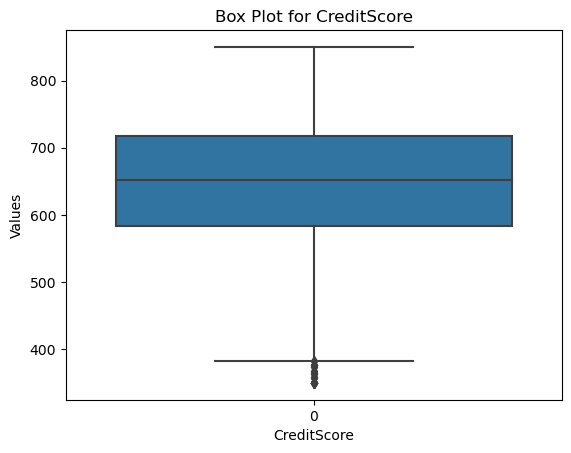

Box Plot for "Age": 



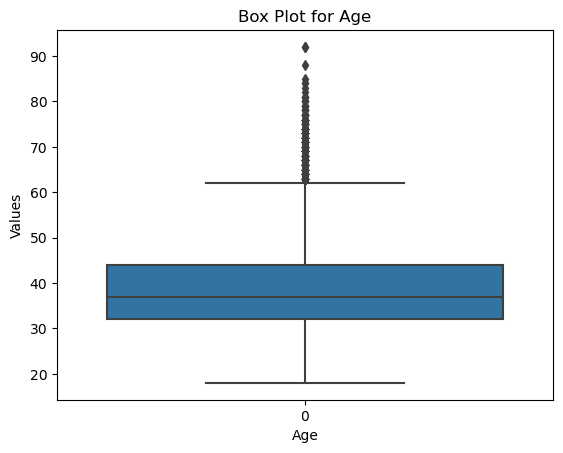

Box Plot for "Tenure": 



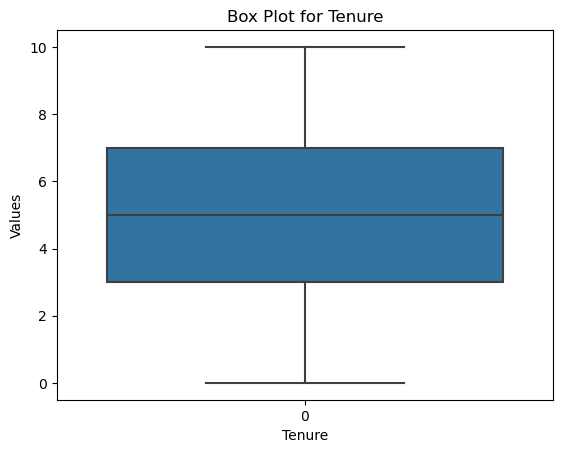

Box Plot for "Balance": 



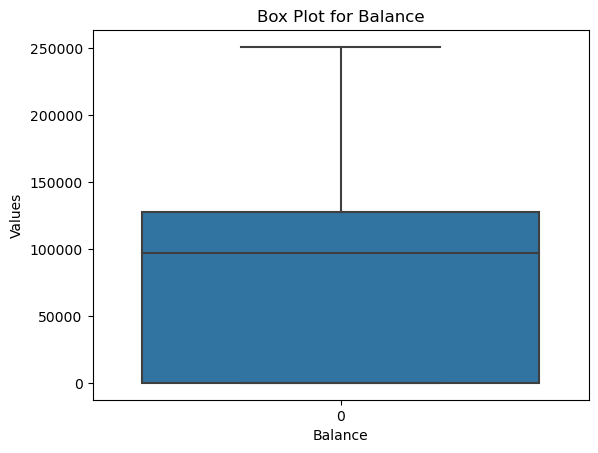

Box Plot for "EstimatedSalary": 



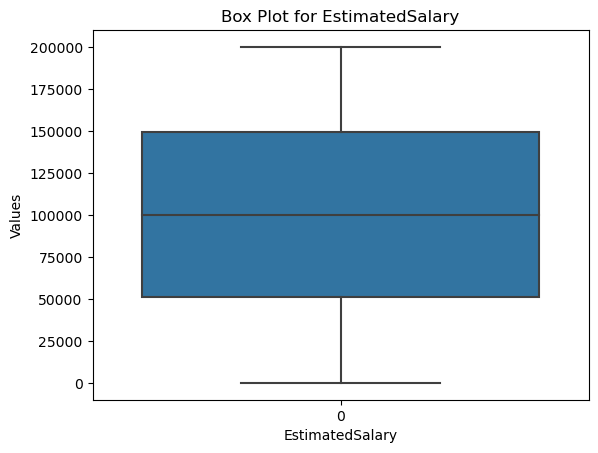

In [17]:
for col in num_cols:
  print(f'Box Plot for "{col}": \n')
  sns.boxplot(data = df_cc_raw[col])
  plt.title(f"Box Plot for {col}")
  plt.xlabel(col)
  plt.ylabel("Values")
  plt.show()

In [18]:
# creating a function to plot categorical and numerical variables by attrition

def plotbytarget(df, array, function_name, hue):
    fig, axarr = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the grid size as needed
    
    sns_function = getattr(sns, function_name)    
    for index, col in enumerate(array):
        sns_function(x=col, hue=hue, data=df, ax=axarr[index // 3][index % 3])
    
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if len(cat_cols) < 6:
        for i in range(len(cat_cols), 6):
            fig.delaxes(axarr[i // 3][i % 3])
    plt.show()

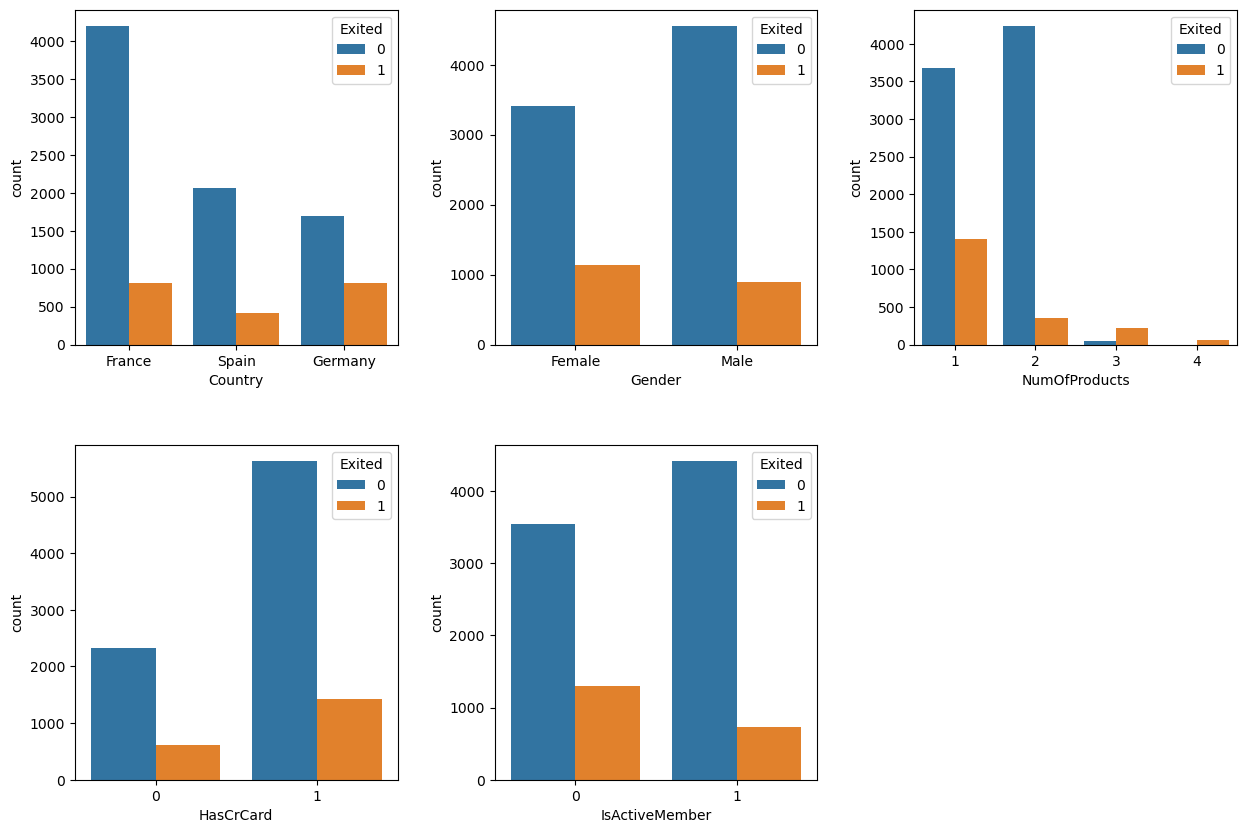

In [19]:
# plotting categorical variables

plotbytarget(df_cc_raw, cat_cols, 'countplot', 'Exited')

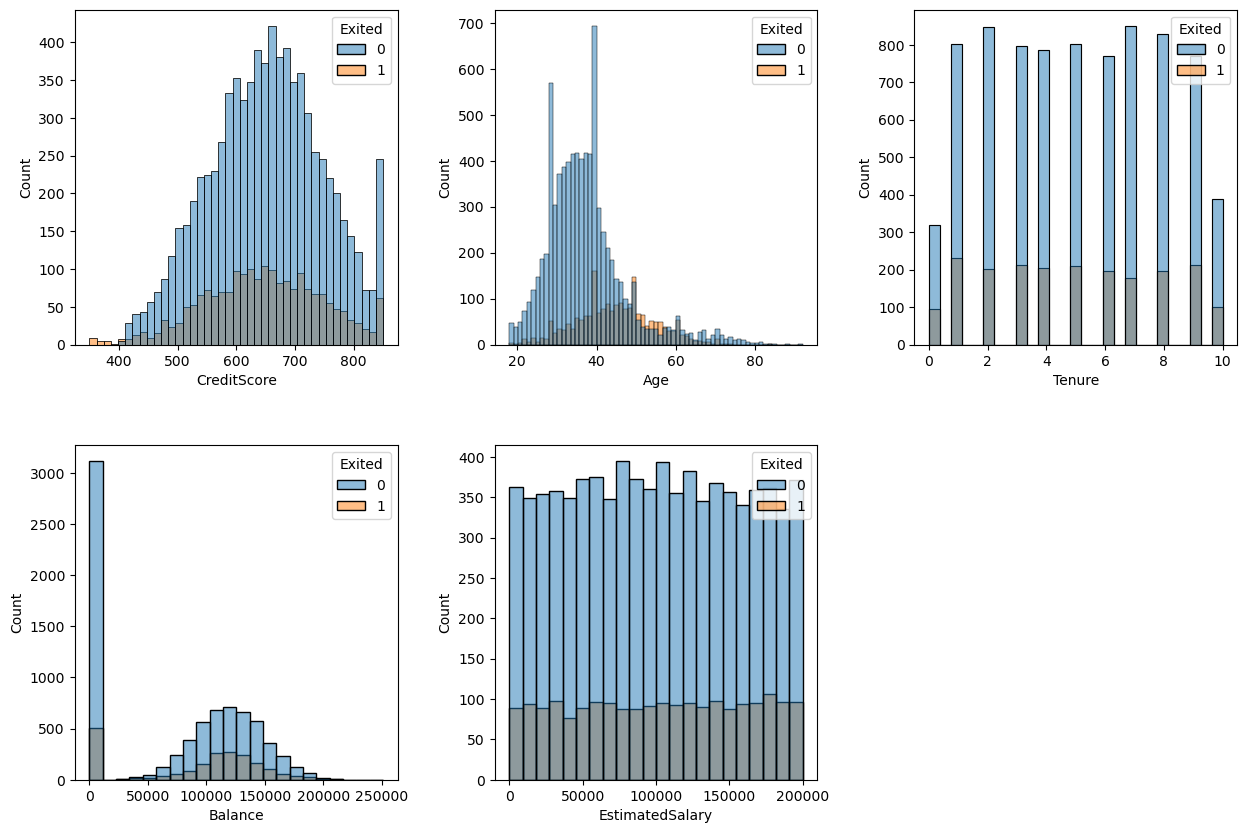

In [20]:
# plotting numerical variables

plotbytarget(df_cc_raw, num_cols, 'histplot', 'Exited')

The above plots offer a view of the class imbalance in the dataset. As seen above, the observations for churned customers are far less than the observations for customers who have not churned.

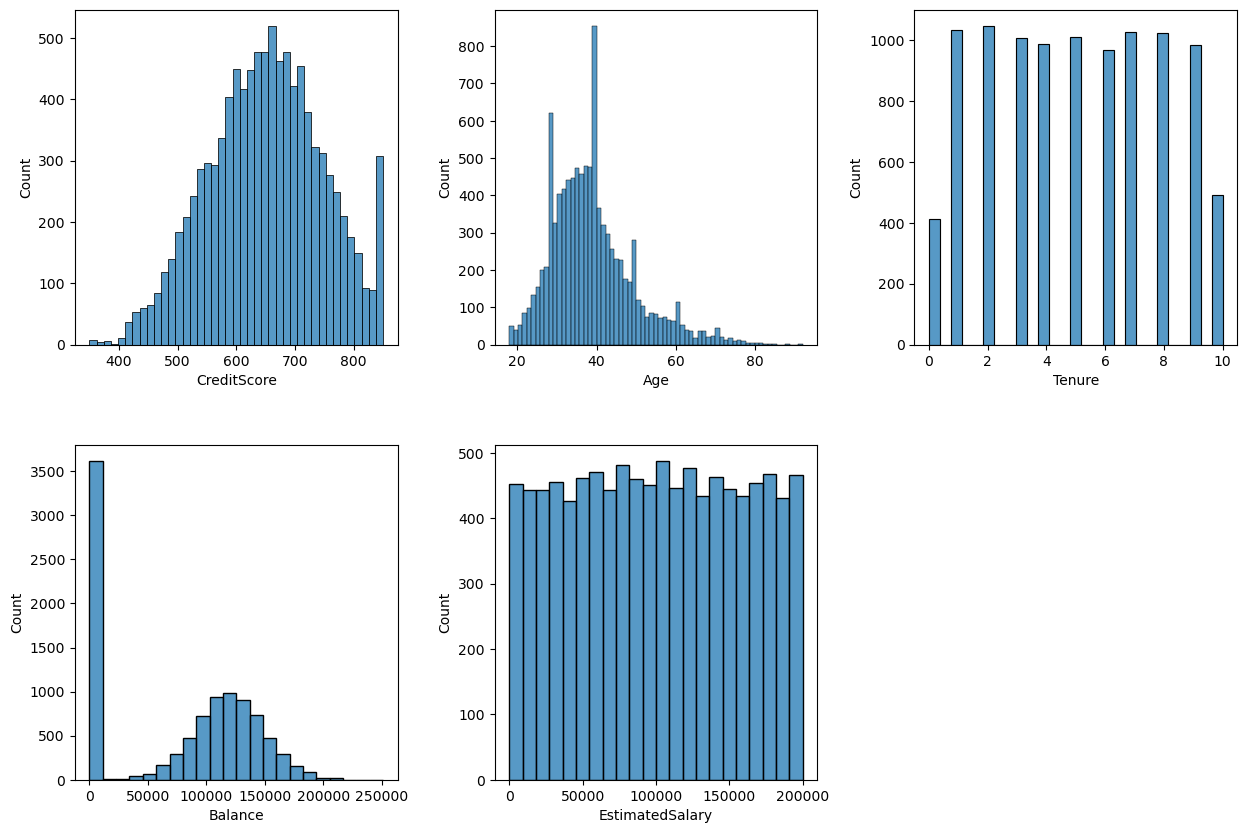

In [21]:
plotbytarget(df_cc_raw, num_cols, 'histplot', hue=None)

From the above data, it can be seen that there is a wide range of values. This increases complexity and may make it hard for the model to capture patterns effectively. In addition the following outlines problems in each variable:

- **CreditScore and Age**: The distributions are skewed and may have outliers
- **Balance and EstimatedSalary**: High variance
- **Tenure**: Raw tenure values can vary significantly based on age - makes age a confounding variable between tenure and target variable. 

To deal with skewness, outliers, and variance, the data could be put into bins. This will also reduce the wide range of values observed into smaller distinct bins (extreme values are treated equally), which would allow the model to make clearer distinctions on how each bin affects the target variable. 

To deal with the confounder in tenure, tenure values could be normalized based on age. A normalized value would provide a consistent scale that accounts for different age groups, making it easier for the model to interpret the individual effect of tenure.

**The above changes except standardizing tenue will be made in feature engineering section of the "Model Building" part of this report.**

In [22]:
df_cc_raw.isna().sum()

CreditScore        0
Country            0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [23]:
# performing one-hot encoding on the categorical variables
df_cc_raw_encoded = pd.get_dummies(df_cc_raw, columns=['Gender', 'Country'])

In [24]:
df_cc_raw.isna().sum()

CreditScore        0
Country            0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [25]:
df_cc = df_cc_raw_encoded
df_cc.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male,Country_France,Country_Germany,Country_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0,0,1


### Testing feature importance using Hypothesis Testing

Among the 13 features in this dataset, there are a few features that intuitively stand out as significant factors to predicting attrition rate. The following section will use hypothesis testing to test the generalized implication of these factors on the attrition rate.

The first relationship to be tested is estimated salary. Does the estimated salary differ across customers that left and customers that stayed? A difference in means t-test will be used to answer this question. 

The reason a t-test is used is because the population mean is unknown. 

Hypothesis:

$H_0: \mu_a = \mu_n$

$H_1: \mu_a \neq \mu_n$

Where $\mu_a$ is the average salary for attrition customers and $\mu_n$ is the average salary for non-attrition customers.

In [26]:
# comparing the sample means from dataset
        
df_exited = df_cc[df_cc['Exited']==0]
df_n_exited = df_cc[df_cc['Exited']==1]
mu_a = df_exited['EstimatedSalary'].mean()
mu_n = df_n_exited['EstimatedSalary'].mean()
print(f'The attrition mean is: {mu_a} \nThe non-attrition mean is: {mu_n}')

The attrition mean is: 99738.39177194524 
The non-attrition mean is: 101465.67753068237


The mean estimated salary does not appear to be significantly different. Let us test if this conclusion can be generalized:

In [27]:
t_stat, p_val = stats.ttest_ind(df_exited['EstimatedSalary'], df_n_exited['EstimatedSalary'])
print(f't_stat: {t_stat} \np-value: {p_val}')

alpha=0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant difference between estimated salaries of exited customers and non-exited customers.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between estimated salaries of exited customers and non-exited customers.")

t_stat: -1.209653638019264 
p-value: 0.22644042802223352
Fail to reject the null hypothesis: There is no significant difference between estimated salaries of exited customers and non-exited customers.


Testing at a 0.05 level of significance ($\alpha$):

The p-value > $\alpha$, so I fail to reject null and conclude that there is not enough evidence to suggest that there is a significant difference between those estimated salaries of customers who left versus those that did not.  

#### Another interesting question that can be explored is: does the country of origin determine difference in attrition? 
    
Since this question is testing the relationship between two categorical variables, the chi-square test of independence will be used to make a generalized claim. 

$H_0 : $ The country of origin is independent of whether the customer leaves (i.e., there is no association between the two variables).

$H_1 : $ The country of origin is not independent of whether the customer leaves (i.e., there is an association between the two variables).


In [28]:
# creating a contingency table
contingency_table = pd.crosstab(df_cc_raw['Country'], df_cc_raw['Exited'])

In [29]:
# performing the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of freedom: {dof}')
print('Expected frequencies:')
print(expected)


alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between country of origin and customer exit.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between country of origin and customer exit.")


Chi-Square statistic: 301.25533682434536
P-value: 3.8303176053541544e-66
Degrees of freedom: 2
Expected frequencies:
[[3992.6482 1021.3518]
 [1997.9167  511.0833]
 [1972.4351  504.5649]]
Reject the null hypothesis: There is a significant association between country of origin and customer exit.


#### Findings from EDA:
- Most of the customers are from France. Spain has the lowest churn rate, compared to France and Germany. Additionally, country of origin has a significant impact on customer exit.
- Most customers have credit cards
- Most numerical continuous columns do not have any outliers, with the exception of age and creditscore. Albeit unlikley, these values are still possible and should be considered in the data - therefore, they will not be defined as outliers
- Some customers are both over the age of 60 and have credit scores below 400. However, they can't be considered as   outliers as albeit unlikely, these occurences are still possible
- Very few customers have more than two bank products
- Inactive customers have a higher churn rate
- Gender and tenure years have little impact on a customer's decision to close a bank account
- Estimated salary has little to no impact on a customer's decision to close a bank account

## Model building to predict customer exit

In [30]:
# setting seed to ensure consistency
SEED = 123

In [31]:
# creating training and testing data
X = df_cc.drop(columns='Exited', axis=1)
y = df_cc['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [32]:
# applying SMOTE to generate synthetic observations and remedy class imbalance
sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [34]:
# standardizing tenure
X_train_res['normalized_tenure'] = X_train_res['Tenure']/X_train_res['Age']

# creating bins for relevant columns
X_train_res['cred_score_binned'] = pd.qcut(X_train_res['CreditScore'], 6, labels=[1,2,3,4,5,6])
X_train_res['age_binned'] = pd.qcut(X_train_res['Age'], 8, labels=[1,2,3,4,5,6,7,8])
X_train_res['est_salary_binned'] = pd.qcut(X_train_res['EstimatedSalary'], 10, labels=[1,2,3,4,5,6,7,8,9,10])

The 'Balance' variable needs to be treated differently. As observed in the above graph, there are a large number of customers with 0 balance. This creates heavy skew in the data. Hence, if balance were binned like the other variables, the edges of the first two bins would be 0, which is incorrect. This problem can be solved by using the "rank" function and then creating bins. This is shown below:

In [35]:
X_train_res['balance_binned'] = pd.qcut(X_train_res['Balance'].rank(method="first"), 5, labels=[1,2,3,4,5])

In [36]:
# checking for NaN values as logistic regression does not fit NaN values
X_train_res.isna().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Gender_Female        0
Gender_Male          0
Country_France       0
Country_Germany      0
Country_Spain        0
normalized_tenure    0
cred_score_binned    0
age_binned           0
est_salary_binned    0
balance_binned       0
dtype: int64

In [37]:
# checking shape to ensure training data is correctly formatted
print(f'{X_train_res.shape}, {y_train_res.shape}')

(12754, 18), (12754,)


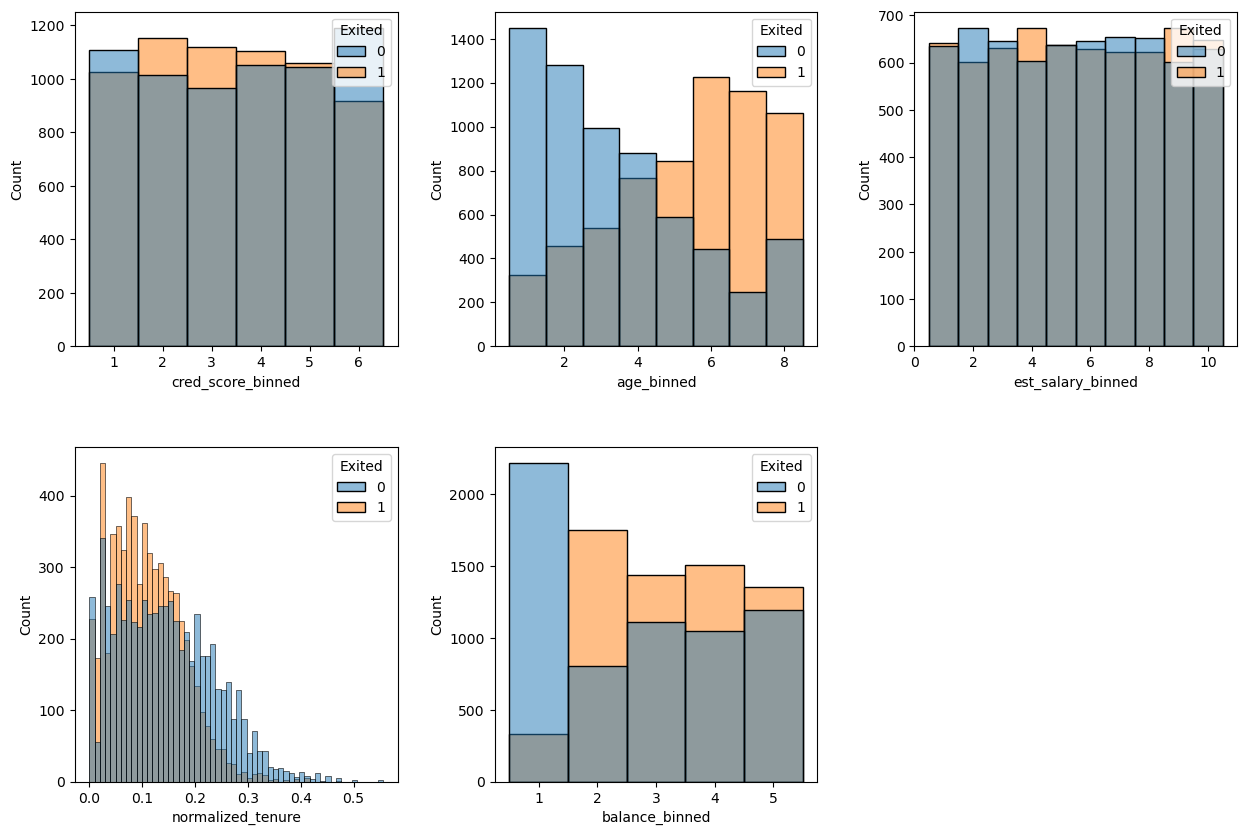

In [39]:
train = pd.concat([X_train_res, y_train_res], axis=1)

# plotting the numerical columns to observe bins and synthetic observations
new_num_cols = ['cred_score_binned', 'age_binned', 'est_salary_binned', 'normalized_tenure', 'balance_binned']
plotbytarget(train, new_num_cols, 'histplot', 'Exited')

In order to make predictions using the model, the feature engineered columns need to be present in the **X_test** set as well. This is done below:

In [40]:
# standardizing tenure
X_test['normalized_tenure'] = X_test['Tenure']/X_test['Age']

# creating bins for relevant columns
X_test['cred_score_binned'] = pd.qcut(X_test['CreditScore'], 6, labels=[1,2,3,4,5,6])
X_test['age_binned'] = pd.qcut(X_test['Age'], 8, labels=[1,2,3,4,5,6,7,8])
X_test['est_salary_binned'] = pd.qcut(X_test['EstimatedSalary'], 10, labels=[1,2,3,4,5,6,7,8,9,10])
X_test['balance_binned'] = pd.qcut(X_test['Balance'].rank(method="first"), 5, labels=[1,2,3,4,5])

In [49]:
# fitting the logistic regression and random forest models

log_model = LogisticRegression(max_iter=1000)
rf1_model = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=SEED)
rf2_model = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=SEED)
lgbm_model = lgb.LGBMClassifier(
    learning_rate=0.7,
    max_delta_step=2,
    n_estimators=100,
    max_depth=10,
    objective='binary',
    random_state=SEED,
    verbose=-1)

In [50]:
# performing cross validation to calculate mean scores and select best model

kf = KFold(n_splits=5, shuffle=True, random_state=42) # defining number of splits of data

# listing valuation metrics
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

log_cv = cross_validate(log_model, X_train_res, y_train_res, cv=kf, scoring=scoring, return_train_score=True)
rf1_cv = cross_validate(rf1_model, X_train_res, y_train_res, cv=kf, scoring=scoring, return_train_score=True)
rf2_cv = cross_validate(rf2_model, X_train_res, y_train_res, cv=kf, scoring=scoring, return_train_score=True)
lgbm_cv = cross_validate(lgbm_model, X_train_res, y_train_res, cv=kf, scoring=scoring, return_train_score=True)

log_mean_scores = {i: np.mean(log_cv[f'test_{i}']) for i in scoring}
rf1_mean_scores = {i: np.mean(rf1_cv[f'test_{i}']) for i in scoring} 
rf2_mean_scores = {i: np.mean(rf2_cv[f'test_{i}']) for i in scoring} 
lgbm_mean_scores = {i: np.mean(lgbm_cv[f'test_{i}']) for i in scoring} 

'''
rf_cv is a dictionary and rf_cv[i] accesses the value for every ith
key in rf_cv
'''

print(f"Logistic Regression Mean Scores:")
for i in log_mean_scores:
    print(f'{i}:{log_mean_scores[i]}')
    
print(f"\nRandom Forest Model 1 Scores:")
for i in rf1_mean_scores:
    print(f'{i}:{rf1_mean_scores[i]}')
    
print(f"\nRandom Forest Model 2 Scores:")
for i in rf2_mean_scores:
    print(f'{i}:{rf2_mean_scores[i]}')
    
print(f"\nLightGBM Model Mean Scores:")
for i in lgbm_mean_scores:
    print(f'{i}:{lgbm_mean_scores[i]}')

Logistic Regression Mean Scores:
accuracy:0.6880203841630733
precision:0.6849925744686056
recall:0.6969840646162584
roc_auc:0.7436477000513664

Random Forest Model 1 Scores:
accuracy:0.8211546413939939
precision:0.837290580017501
recall:0.7973123041498326
roc_auc:0.9023416477403201

Random Forest Model 2 Scores:
accuracy:0.8705500803222112
precision:0.8850937966485105
recall:0.8516631238351453
roc_auc:0.9430639035585475

LightGBM Model Mean Scores:
accuracy:0.8876431080468251
precision:0.8997943349683173
recall:0.8725201924311721
roc_auc:0.9513840459975406


In [55]:
# printing the cross_validate dictionary and the mean_score dictionaries to understand the structure better so 
# that I can define the compare_models function in the next cell

print(f'rf1_cv : {rf1_cv} \nlog_mean_scores : {log_mean_scores}')

rf1_cv : {'fit_time': array([0.69722176, 0.5593009 , 0.63620496, 0.59321404, 0.61373329]), 'score_time': array([0.04290009, 0.04302096, 0.04441309, 0.04604602, 0.04264975]), 'test_accuracy': array([0.81771854, 0.81928655, 0.81967856, 0.82163857, 0.82745098]), 'train_accuracy': array([0.82799177, 0.82201313, 0.82720768, 0.82495345, 0.82585261]), 'test_precision': array([0.84481328, 0.83401808, 0.8219291 , 0.84380165, 0.84189079]), 'train_precision': array([0.84387924, 0.83343477, 0.83899497, 0.84288086, 0.84514654]), 'test_recall': array([0.78549383, 0.7967033 , 0.80338437, 0.79331779, 0.80766224]), 'train_recall': array([0.80318835, 0.80501666, 0.8126947 , 0.7978389 , 0.79756767]), 'test_roc_auc': array([0.89920472, 0.90136136, 0.90668539, 0.90409358, 0.90036319]), 'train_roc_auc': array([0.90883246, 0.90437055, 0.90711489, 0.90593435, 0.90609842])} 
log_mean_scores : {'accuracy': 0.6880203841630733, 'precision': 0.6849925744686056, 'recall': 0.6969840646162584, 'roc_auc': 0.7436477000

In [56]:
# creating function to determine best model for each valuation metric 
def compare_models(scores1, scores2, scores3, scores4, model_names):
    metrics = list(scores1.keys())
    for i in metrics:
        print(f"\nComparison of {i}:")
        print(f"{model_names[0]}: {scores1[i]}")
        print(f"{model_names[1]}: {scores2[i]}")
        print(f"{model_names[2]}: {scores3[i]}")
        print(f"{model_names[3]}: {scores4[i]}")
        best_model = max((scores1[i], model_names[0]), (scores2[i], model_names[1]), (scores3[i], model_names[2]), (scores4[i], model_names[3]))
        print(f"Best model for {i}: {best_model[1]} with score {best_model[0]}")

compare_models(log_mean_scores, rf1_mean_scores, rf2_mean_scores, lgbm_mean_scores, ['Logistic Regression', 'Random Forest 1', 'Random Forest 2', 'LightGBM'])


Comparison of accuracy:
Logistic Regression: 0.6880203841630733
Random Forest 1: 0.8211546413939939
Random Forest 2: 0.8705500803222112
LightGBM: 0.8876431080468251
Best model for accuracy: LightGBM with score 0.8876431080468251

Comparison of precision:
Logistic Regression: 0.6849925744686056
Random Forest 1: 0.837290580017501
Random Forest 2: 0.8850937966485105
LightGBM: 0.8997943349683173
Best model for precision: LightGBM with score 0.8997943349683173

Comparison of recall:
Logistic Regression: 0.6969840646162584
Random Forest 1: 0.7973123041498326
Random Forest 2: 0.8516631238351453
LightGBM: 0.8725201924311721
Best model for recall: LightGBM with score 0.8725201924311721

Comparison of roc_auc:
Logistic Regression: 0.7436477000513664
Random Forest 1: 0.9023416477403201
Random Forest 2: 0.9430639035585475
LightGBM: 0.9513840459975406
Best model for roc_auc: LightGBM with score 0.9513840459975406


#### As observed from the above, the best model for every valuation metric is the LightGBM model, with an accuracy of 88.7%. 